# <center> Gender Biais detection</center>
## <center> A first approach from the Bolukbasi Paper </center>
### <center> Quillivic Robin </center>
Sources : Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings, Bolukbasi, Tolga, 2016


In [1]:
from gensim import *
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
import logging
import gensim
import os

from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
from random import *

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import lib

C:\Users\Robin\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## DATA

In [2]:
# Logging code taken from http://rare-technologies.com/word2vec-tutorial/
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\ENG\GoogleNews-vectors-negative300.bin', binary=True,limit=50000)

# normalizeation :
model.init_sims(True)

2019-02-24 12:08:51,362 : INFO : loading projection weights from DATA\ENG\GoogleNews-vectors-negative300.bin
2019-02-24 12:08:52,105 : INFO : loaded (50000, 300) matrix from DATA\ENG\GoogleNews-vectors-negative300.bin
2019-02-24 12:08:52,106 : INFO : precomputing L2-norms of word weight vectors


In [3]:
res = lib.association_Genrator('man','woman',model,top_n=1000)
res.head(20)

,pair,score
21798,"(he, she)",0.753054
25689,"(his, her)",0.728875
313191,"(women, men)",0.674629
55507,"(He, She)",0.666475
71243,"(she, him)",0.592754
64747,"(her, him)",0.591657
25696,"(his, she)",0.590054
71954,"(she, himself)",0.585276
65458,"(her, himself)",0.572458
488385,"(mother, father)",0.558581


## COSINE similarity

In [20]:
def cosine_similarity(w1,w2) :
    return(np.dot(w1, w2)/(np.linalg.norm(w1)* np.linalg.norm(w2)) )

In [59]:
print('-1 is the most feminine word we can imagine and 1 is the most Masculine word')

word_list = ['waitress','France','spoon','football','dance','swim','education']
for word in word_list :
    print(' The gender composant of ',word, ':', cosine_similarity(direction_g,model[word]))

-1 is the most feminine word we can imagine and 1 is the most Masculine word
 The gender composant of  waitress : -0.31816196
 The gender composant of  France : -0.053371724
 The gender composant of  spoon : -0.008224052
 The gender composant of  football : 0.18628497
 The gender composant of  dance : -0.13523267
 The gender composant of  swim : -0.05620065
 The gender composant of  education : -0.06364788


## 1) Direct Biais

In [8]:
Gender_Pair = [['she','he'],['woman','man'],['her','his'],['Mary','John'],['herself','himself'],['daughter','son'],
               ['mother','father'],['gal','guy'],['sister','brother'],['female','male'],['girl','boy'], ['spokesman','spokeswoman'],
               ['stepmother','stepfather'],['queen','king'],['businesswoman','businessman'],['actor','actress'],
               ['boyfriend','girlfriend'],['twin_sister','twin_brother']]

               

In [9]:
def create_random_pair(n,model):
    """
    Function that creates n random pairs of word, using the model of Google news
    Entry: 
    - n: type:int Nunber of pair needed
    Output: 
    - Pair: type:List ; list of pair size: nx2
    """
    df = pd.DataFrame(list(model.wv.vocab.items()), columns=['word','count'])
    list_word = list(df['word'])
    shuffle(list_word)
    
    Pair=[]
    for i in range(n):
        Pair.append([list_word[i],list_word[2*i]])
    return(Pair)

def from_pair_to_subspace(Pair,model):
    """
    Entry:
    - Pair: type:List  size:nx2 ; list of pair word
    Output:
    - SubS: type:Array size: 300xn ; array of the word representation for each difference of word pair
    
    Example:
    Pair = [['man','woman']]
    Subs = np.array(model.wv(man) - model.wv(woman))
    """
    print('There are ',len(Pair), 'pairs of words. This is also the future dimension of our subspace')
    SubS=[]
    for i in range(len(Pair)):
        SubS.append(model.wv[Pair[i][0]]-model.wv[Pair[i][1]])
    return(np.array(SubS))

def from_space_to_direction(SubS):
    """
    Extraction of the  principale component  of the subspace created from the differences of word pair
    Entry :
    - SubS: type:Array size: 300xn ; array of the word representation for each difference of word pair
    Output:
    - direction : principal component of the PCA
    - expl_var : explained_variance_ratio_ of the pca
    - eig_values: eig_values of the pca
    """
    n_c = int(len(SubS)/2)
    print('the dim initial is',len(SubS[0]))
    # Now we are doinf a PCA
    pca = PCA(n_components=n_c)
    pca.fit(SubS)
    Y_pca = pca.fit_transform(SubS)
    eig_values = pca.singular_values_
    expl_var = pca.explained_variance_ratio_
    direction = pca.components_[0]
    return(direction, expl_var,eig_values)

def plot_var_eig(eig_values,expl_var):
    """
    plot the explained variance and theeigen values of the  pca
    """
    plt.figure(figsize = (20,10))
    plt.subplot(121)
    plt.bar(np.arange(len(eig_values)),eig_values)
    plt.title('The eigen values for the subspace',fontsize=18)
    
    ##
    plt.subplot(122)
    plt.bar(np.arange(len(expl_var)),expl_var)
    plt.title('The variance explained by each of the selected components',fontsize=18)
    plt.show()
    
        

In [10]:
subs_genre = from_pair_to_subspace(Gender_Pair,model)
direction_g, expl_var_g,eig_values_g = from_space_to_direction(subs_genre)

subs_rand = from_pair_to_subspace(create_random_pair(20,model),model)
direction_r, expl_var_r,eig_values_r = from_space_to_direction(subs_rand)


There are  18 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300


C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


## Example for direct Biais

In [13]:
word =['table','apple','engineer','woman','student','art','mathematics','music','football','skirt','love','amazing','house','adventure','brother']

In [14]:
for w in word :
    print('the direct biais for',w,'is : ', lib.cosine_similarity(model[w],direction_g))

the direct biais for table is :  -0.011391642
the direct biais for apple is :  0.0032776038
the direct biais for engineer is :  0.16758615
the direct biais for woman is :  -0.29943568
the direct biais for student is :  -0.055797637
the direct biais for art is :  -0.06484599
the direct biais for mathematics is :  -0.0010758435
the direct biais for music is :  -0.0062112287
the direct biais for football is :  0.19962436
the direct biais for skirt is :  -0.24485657
the direct biais for love is :  -0.036990084
the direct biais for amazing is :  -0.035350118
the direct biais for house is :  -0.044906497
the direct biais for adventure is :  0.023235396
the direct biais for brother is :  0.30007762


## Illustration f the PCA for random and gender subspace

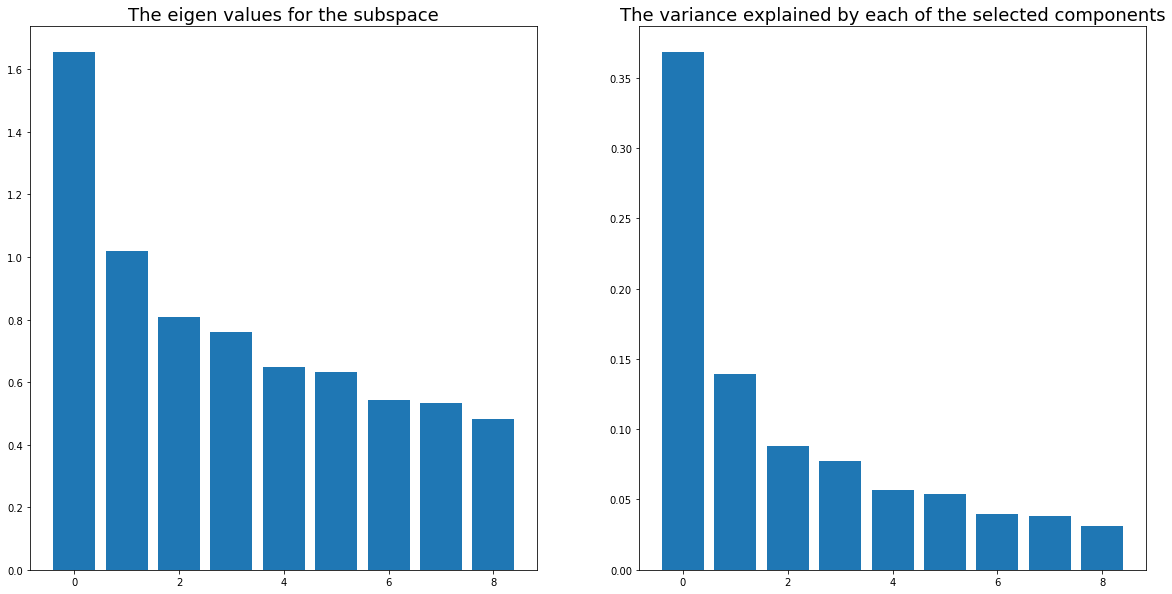

In [72]:
 plot_var_eig(eig_values_g,expl_var_g)

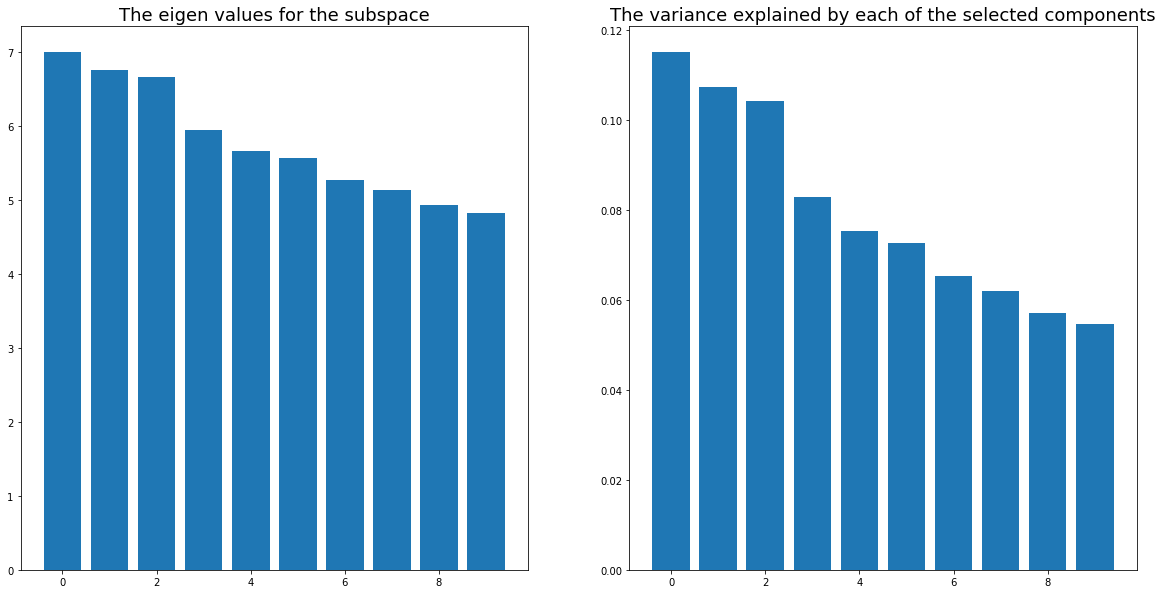

In [10]:
 plot_var_eig(eig_values_r,expl_var_r)

### Comment :
We observe as, in the paper of bolukbasi an important composant for the gender subspace. To confirm thi hypothesis, we are going to do it with the mean of severals random subspace.

In [1]:
def plot_mean(n,model) :
    Rand_var =[]
    Rand_eig  = []
    for i in range(n):
        subs_rand = from_pair_to_subspace(create_random_pair(20,model),model)
        direction_r, expl_var_r,eig_values_r = from_space_to_direction(subs_rand)
        Rand_var.append(expl_var_r)
        Rand_eig.append(eig_values_r)
    return(Rand_var,Rand_eig)
    

In [18]:
Rand_var,Rand_eig = plot_mean(1000,model)

C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the fut

There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our subspace
the dim initial is 300
There are  20 pairs of words. This is also the future dimension of our su

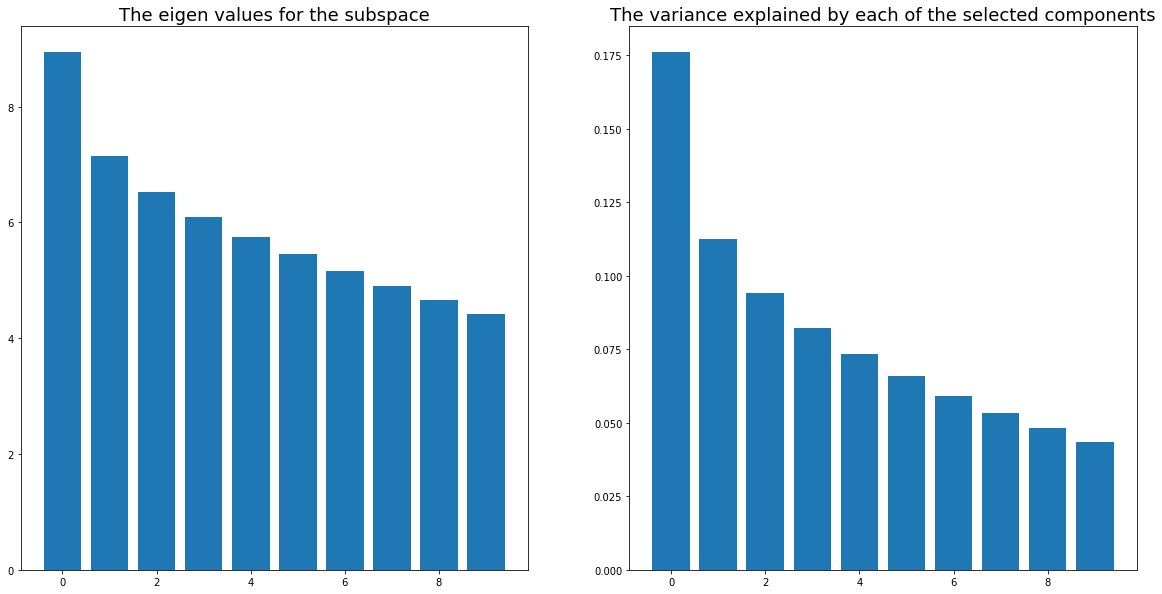

In [19]:
 plot_var_eig(np.asarray(Rand_eig).mean(axis=0) , np.asarray(Rand_var).mean(axis=0))

## Comment : 
For the mean of 100 simulation we observe the same phenomenon : by taking random vectors, we observe small variance difference between the principal components.

## 2) Indirect Biais

In [51]:
def projection(w,direction):
    """
    return the projection of w on the vector "direction"
    """
    return(np.dot(direction,np.dot(direction,w)))

def indirect_biais(w1,w2,direction):
    """
    return the indirect Biais
    
    """
    
    w1_t = w1-projection(w1,direction)
    w2_t = w2-projection(w2,direction)
    norm= np.linalg.norm(w1)* np.linalg.norm(w2)
    norm_t = np.linalg.norm(w1_t)* np.linalg.norm(w2_t)
    return((np.dot(w1, w2)-np.dot(w1_t,w2_t)/norm_t)/norm)
    

In [46]:
np.dot(model['softball'],direction_g)

-0.19997904

In [47]:
np.dot(model['football'],direction_g)

0.18628503

In [52]:
print(indirect_biais(model['softball'],model['waitress'],direction_g))
print(indirect_biais(model['football'],model['waitress'],direction_g))

0.05429232
-0.06663749


In [54]:
print(indirect_biais(model['softball'],model['homemaker'],direction_g))
print(indirect_biais(model['football'],model['homemaker'],direction_g))

0.05828558
-0.06997701


In [56]:
print(indirect_biais(model['softball'],model['cocky'],direction_g))
print(indirect_biais(model['football'],model['cocky'],direction_g))

-0.03280291
0.023060203


In [58]:
print(indirect_biais(model['softball'],model['divorce'],direction_g))
print(indirect_biais(model['football'],model['divorce'],direction_g))

0.017917197
-0.019322835
